In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from imblearn.ensemble import BalancedRandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [4]:
pitchers_df = pd.read_csv('Combined CSV\Pitchers_Complete.csv')


In [5]:
pitchers_df.shape

(9427, 34)

In [6]:
pitchers_df.columns

Index(['playerID', 'nameFirst', 'nameLast', 'weight', 'height', 'bats_L',
       'bats_R', 'throws_L', 'throws_R', 'Seasons', 'Wins', 'Losses', 'Games',
       'Pitch_Starts', 'Complete_Games', 'Shutouts', 'Saves', 'Outs_Pitched',
       'Hits', 'Earned_Runs', 'Home_Runs', 'Walks', 'Strikeouts',
       'Batters_Faced', 'Games_Finished', 'Runs_Allowed', 'finalGame',
       'Retired_Years', 'inducted', 'yearID', 'Total_Games', 'Games_Started',
       'Primary_Position', 'Hall_Eligible'],
      dtype='object')

In [7]:
pitchers_df.head()

,playerID,nameFirst,nameLast,weight,height,bats_L,bats_R,throws_L,throws_R,Seasons,...,Games_Finished,Runs_Allowed,finalGame,Retired_Years,inducted,yearID,Total_Games,Games_Started,Primary_Position,Hall_Eligible
0,aardsda01,David,Aardsma,215.0,75.0,0,1,0,1,9,...,141,169,2015-08-23,6.720548,0,0.0,331,0.0,Pitcher,0
1,aasedo01,Don,Aase,190.0,75.0,0,1,0,1,13,...,235,503,1990-10-03,31.624658,0,0.0,448,91.0,Pitcher,1
2,abadfe01,Fernando,Abad,235.0,74.0,1,0,1,0,12,...,101,155,2021-10-01,0.608219,0,0.0,400,6.0,Pitcher,0
3,abbeybe01,Bert,Abbey,175.0,71.0,0,1,0,1,7,...,14,442,1896-09-23,125.712329,0,0.0,79,0.0,Pitcher,0
4,abbotco01,Cory,Abbott,210.0,73.0,0,1,0,1,1,...,2,15,2021-10-02,0.605479,0,0.0,8,1.0,Pitcher,0


In [8]:
pitchers_train_model = pitchers_df[pitchers_df['Hall_Eligible']==1]
pitchers_train_model.head()

,playerID,nameFirst,nameLast,weight,height,bats_L,bats_R,throws_L,throws_R,Seasons,...,Games_Finished,Runs_Allowed,finalGame,Retired_Years,inducted,yearID,Total_Games,Games_Started,Primary_Position,Hall_Eligible
1,aasedo01,Don,Aase,190.0,75.0,0,1,0,1,13,...,235,503,1990-10-03,31.624658,0,0.0,448,91.0,Pitcher,1
6,abbotgl01,Glenn,Abbott,200.0,78.0,0,1,0,1,13,...,13,707,1984-08-08,37.780822,0,0.0,248,204.0,Pitcher,1
7,abbotji01,Jim,Abbott,200.0,75.0,1,0,1,0,12,...,5,880,1999-07-21,22.821918,0,0.0,263,254.0,Pitcher,1
9,abbotpa01,Paul,Abbott,185.0,75.0,0,1,0,1,13,...,17,421,2004-08-07,17.769863,0,0.0,162,112.0,Pitcher,1
10,aberal01,Al,Aber,195.0,74.0,1,0,1,0,10,...,76,205,1957-09-11,64.706849,0,0.0,168,30.0,Pitcher,1


In [9]:
scale_pos_weight = (pitchers_train_model.inducted.value_counts()[0])/pitchers_train_model.inducted.value_counts()[1]
print(scale_pos_weight)

22.014492753623188


In [10]:
# Getting data ready for machine learning
data = pitchers_train_model.drop(['inducted', 
                                  'playerID', 
                                  'nameFirst', 
                                  'nameLast', 
                                  'finalGame', 
                                  'bats_L',
                                  'bats_R', 
                                  'throws_L', 
                                  'throws_R',
                                  'weight', 
                                  'height',
                                  'yearID',
                                  'Retired_Years',
                                  'Primary_Position',
                                  'Hall_Eligible'], axis=1)
data.fillna(0, inplace=True)
data['Batters_Faced']=pd.to_numeric(data['Batters_Faced'])
target = pitchers_train_model['inducted']
target.fillna('0', inplace=True)
feature_names = data.columns

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [12]:
len(X_test)

397

In [13]:
#CLF = Classifier
clf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
clf = clf.fit(X_train_scaled, y_train)
clf.score(X_test_scaled, y_test)

0.9193954659949622

In [14]:
y_predicted = clf.predict(X_test_scaled)
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.metrics import classification_report_imbalanced
print(confusion_matrix(y_test, y_predicted))

predictions_df = pd.concat([pd.DataFrame(X_test_scaled),              
                            pd.DataFrame(dict(predicted= y_predicted,actual=y_test
                            )).reset_index(drop=True)], axis=1)

[[349  32]
 [  0  16]]


In [15]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_predicted))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.92      1.00      0.96      0.96      0.91       381
          1       0.33      1.00      0.92      0.50      0.96      0.92        16

avg / total       0.97      0.92      1.00      0.94      0.96      0.91       397



In [16]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_predicted) 

0.958005249343832

In [17]:
# List the features sorted in descending order by feature importance
sorted(zip(clf.feature_importances_, data.columns), reverse=True)

[(0.2170952001457168, 'Wins'),
 (0.12248129821615245, 'Shutouts'),
 (0.09316543313283455, 'Outs_Pitched'),
 (0.08812121435894245, 'Batters_Faced'),
 (0.07139720738513751, 'Strikeouts'),
 (0.06673089651986526, 'Complete_Games'),
 (0.052280821539729766, 'Pitch_Starts'),
 (0.04326961510803722, 'Games_Finished'),
 (0.035567284562043416, 'Hits'),
 (0.03226825106887484, 'Total_Games'),
 (0.031868112918766595, 'Walks'),
 (0.03137362392494385, 'Saves'),
 (0.029928402690281214, 'Games'),
 (0.023820293804366517, 'Runs_Allowed'),
 (0.01956171910249932, 'Losses'),
 (0.012737724820838186, 'Earned_Runs'),
 (0.011552226403226404, 'Games_Started'),
 (0.009394194943765729, 'Home_Runs'),
 (0.0073864793539777426, 'Seasons')]

<BarContainer object of 19 artists>

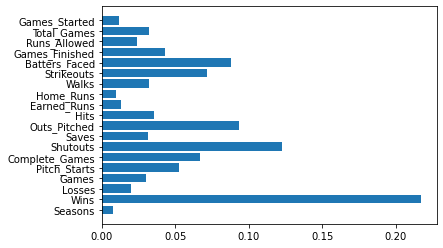

In [18]:
plt.barh(feature_names,clf.feature_importances_)

In [19]:
predictions_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,predicted,actual
0,0.987501,2.779308,1.410357,0.909812,2.336333,1.817139,3.739248,-0.429064,2.500401,1.941870,...,2.339857,2.712745,2.380524,2.381079,-0.737260,1.455326,0.937065,2.489993,1,1
1,0.750668,0.255197,0.268212,2.509055,-0.969060,-0.599408,-0.773630,2.562476,-0.117365,-0.130425,...,0.333936,-0.489028,0.082060,-0.157516,3.763509,-0.276225,2.438233,-0.905380,0,0
2,0.513835,1.609598,0.789190,0.286659,1.145321,1.593167,1.780829,-0.286610,1.314453,1.296995,...,0.754932,0.782909,0.534866,1.283611,-0.334687,0.957828,0.302998,1.253449,1,0
3,-1.143998,-1.053031,-1.054272,-1.533169,-0.674653,-0.516892,-0.092441,-0.460720,-1.042180,-1.129309,...,-0.755701,-0.883767,-0.833882,-1.061113,-0.688951,-1.066622,-1.528751,-0.604784,0,0
4,-1.143998,0.870834,0.689002,-0.182085,0.569888,1.498862,1.525383,-0.223297,0.896303,0.672822,...,-0.904288,0.641208,0.452225,0.806970,-0.197812,0.410796,0.102481,0.665919,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,-0.670331,-1.083813,-1.414950,-0.579138,-1.136337,-0.670137,-0.773630,-0.302438,-1.149685,-1.150011,...,-1.201461,-1.170543,-1.155839,-1.166817,-0.173657,-1.197996,-0.623715,-1.076174,0,0
393,-1.143998,-0.191139,-0.212692,-0.849355,-0.045691,0.237542,0.077856,-0.460720,-0.174678,-0.167689,...,-0.631879,0.610843,-0.635887,-0.120252,-0.487665,0.005906,-0.883845,0.030568,0,0
394,2.645334,1.624989,2.031523,0.970473,1.941559,1.251314,2.291721,-0.413236,1.890301,1.904606,...,1.745510,1.876033,1.493850,1.901272,-0.423253,1.791298,1.115905,2.066426,1,0
395,0.513835,0.193634,0.228136,1.516421,-0.259806,-0.257555,-0.007292,1.802720,0.230246,0.187355,...,0.148202,0.212730,0.471163,0.222433,2.201525,0.096360,1.533197,-0.181216,0,0


In [20]:
import os
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [21]:
# fit model to training data
XGmodel = XGBClassifier(scale_pos_weight=1)
XGmodel.fit(X_train_scaled, y_train)
y_pred = XGmodel.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

In [22]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
predictions_df = pd.concat([pd.DataFrame(X_test_scaled),
#                            .copy().assign(
                           pd.DataFrame(dict(
    predicted= y_pred,
    actual=y_test
)).reset_index(drop=True)
                           ], axis=1)
actual_inductees = predictions_df.loc[predictions_df.actual==1]
predictions_for_actual_inductees = actual_inductees.predicted.value_counts()
print(predictions_for_actual_inductees)


[[376   5]
 [  5  11]]
1    11
0     5
Name: predicted, dtype: int64


<BarContainer object of 19 artists>

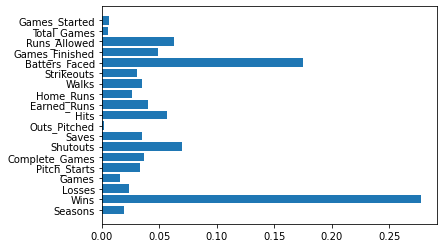

In [23]:
plt.barh(feature_names,XGmodel.feature_importances_)

In [24]:
# Run all data through the model to determine who should be in the hall of fame.
data_total = pitchers_df.drop(['inducted', 
                                  'playerID', 
                                  'nameFirst', 
                                  'nameLast', 
                                  'finalGame', 
                                  'bats_L',
                                  'bats_R', 
                                  'throws_L', 
                                  'throws_R',
                                  'weight', 
                                  'height',
                                  'yearID',
                                  'Retired_Years',
                                  'Primary_Position',
                                  'Hall_Eligible'], axis=1)
data_total.fillna(0, inplace=True)
data_total['Batters_Faced'].fillna(0, inplace=True)
data_total['Batters_Faced']=pd.to_numeric(data['Batters_Faced'])
# data_total.head()
data_total=data_total.fillna(0)
data_total.head()

,Seasons,Wins,Losses,Games,Pitch_Starts,Complete_Games,Shutouts,Saves,Outs_Pitched,Hits,Earned_Runs,Home_Runs,Walks,Strikeouts,Batters_Faced,Games_Finished,Runs_Allowed,Total_Games,Games_Started
0,9,16,18,331,0,0,0,69,1011,296,160,41,183,340,0.0,141,169,331,0.0
1,13,66,60,448,91,22,5,82,3328,1085,468,89,457,641,4730.0,235,503,448,91.0
2,12,8,29,400,6,0,0,2,1045,332,146,43,123,290,0.0,101,155,400,6.0
3,7,22,40,79,65,52,0,1,1704,686,285,18,192,161,0.0,14,442,79,0.0
4,1,0,0,7,1,0,0,0,52,20,13,7,11,12,0.0,2,15,8,1.0


In [25]:
data_total_scaler = StandardScaler().fit(data_total)
data_total_scaled = data_total_scaler.transform(data_total)
data_total_predicted = XGmodel.predict(data_total_scaled)

In [26]:
pitchers_predict_df = pd.concat([pitchers_df, pd.Series(data_total_predicted)], axis=1)
pitchers_predict_df = pitchers_predict_df.rename(columns={0:'model_predict'})
pitchers_predict_df['Comparison']=pitchers_predict_df['inducted']==pitchers_predict_df['model_predict']
pitchers_predict_df.head()

,playerID,nameFirst,nameLast,weight,height,bats_L,bats_R,throws_L,throws_R,Seasons,...,finalGame,Retired_Years,inducted,yearID,Total_Games,Games_Started,Primary_Position,Hall_Eligible,model_predict,Comparison
0,aardsda01,David,Aardsma,215.0,75.0,0,1,0,1,9,...,2015-08-23,6.720548,0,0.0,331,0.0,Pitcher,0,0,True
1,aasedo01,Don,Aase,190.0,75.0,0,1,0,1,13,...,1990-10-03,31.624658,0,0.0,448,91.0,Pitcher,1,0,True
2,abadfe01,Fernando,Abad,235.0,74.0,1,0,1,0,12,...,2021-10-01,0.608219,0,0.0,400,6.0,Pitcher,0,0,True
3,abbeybe01,Bert,Abbey,175.0,71.0,0,1,0,1,7,...,1896-09-23,125.712329,0,0.0,79,0.0,Pitcher,0,0,True
4,abbotco01,Cory,Abbott,210.0,73.0,0,1,0,1,1,...,2021-10-02,0.605479,0,0.0,8,1.0,Pitcher,0,0,True


In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='euclidean')

In [29]:
y_pred = knn.predict(X_test_scaled)

In [30]:
from imblearn.over_sampling import ADASYN 

In [31]:
ada = ADASYN()
X_ada, y_ada = ada.fit_sample(X_train_scaled,y_train)

In [32]:
clf_ada = BalancedRandomForestClassifier(random_state=0)
clf_ada = clf.fit(X_ada, y_ada)
clf.score(X_test_scaled, y_test)

0.9571788413098237

In [33]:
y_predicted_ada = clf_ada.predict(X_test_scaled)
# from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_predicted_ada))

predictions_df = pd.concat([pd.DataFrame(X_test_scaled),
#                            .copy().assign(
                           pd.DataFrame(dict(
    predicted= y_predicted_ada,
    actual=y_test
)).reset_index(drop=True)
                           ], axis=1)
# pd.Series(y_test).value_counts()#[:20]
actual_inductees = predictions_df.loc[predictions_df.actual=='1']
predictions_for_actual_inductees = actual_inductees.predicted.value_counts()


[[367  14]
 [  3  13]]


<BarContainer object of 19 artists>

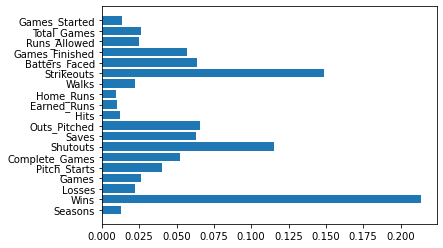

In [34]:
plt.barh(feature_names,clf_ada.feature_importances_)

In [35]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled,y_train)
model_smote_tomek = XGBClassifier(scale_pos_weight=1)
model_smote_tomek.fit(X_resampled, y_resampled)
y_pred_smote_tomek = model_smote_tomek.predict(X_train_scaled)
print(len(X_resampled), len(y_resampled))

2276 2276


In [36]:
predictions_df = pd.concat([pd.DataFrame(X_resampled),
                           pd.DataFrame(dict(
    predicted= y_pred_smote_tomek,
    actual=y_test
)).reset_index(drop=True) ], axis=1)
actual_inductees = predictions_df.loc[predictions_df.actual=='1']
predictions_for_actual_inductees = actual_inductees.predicted.value_counts()
print(classification_report(y_test, y_pred_smote_tomek))

ValueError: array length 1191 does not match index length 397